In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score

from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance

import pickle

In [ ]:
project_accidents_df = pd.read_csv('../data/agg_df.csv')

In [11]:
# Filter the DataFrame for accidents that occurred in Paris (department code 75)
eel_de_frans_df = project_accidents_df[project_accidents_df["region"] == "Île-de-France"]

pd.set_option('display.max_columns', None)
eel_de_frans_df.head()

,date,day_of_week,hour,accident_number,road_category,road_layout,num_lanes,reserved_lane,road_profile,road_shape,surface_condition,infrastructure,road_location,speed_limit,injury_severity,users_involved,light_conditions,department,urban_area,intersection_type,weather,collision_type,latitude,longitude,region
0,2019-11-30,Saturday,1,201900000001,Major Roads,Multi Lane,10,No value,Flat,Curved,Normal,Tunnel / Bridge,Road,70,1,3,Night,93,Outside urban area,No junction,Normal,2-car collision,48.896210,2.470120,Île-de-France
1,2019-11-30,Saturday,2,201900000002,Major Roads,One Way,2,No value,Slope / Near Slope,Curved,Normal,No value,Road,70,1,1,Night,93,Outside urban area,No junction,Normal,Multi-car collision,48.930700,2.368800,Île-de-France
2,2019-11-28,Thursday,15,201900000003,Major Roads,Multi Lane,8,No value,Flat,Curved,Normal,No value,Road,90,1,4,Day,92,Outside urban area,No junction,Normal,Multi-car collision,48.935872,2.319174,Île-de-France
3,2019-11-30,Saturday,20,201900000004,Major Roads,Multi Lane,5,No value,Flat,Straight,Normal,No value,Road,90,1,4,Night,94,Outside urban area,No junction,Normal,Multi-car collision,48.817329,2.428150,Île-de-France
4,2019-11-30,Saturday,4,201900000005,Major Roads,One Way,3,No value,Flat,Curved,Normal,Tunnel / Bridge,Road,90,1,3,Night,94,Outside urban area,No junction,Normal,2-car collision,48.776362,2.433254,Île-de-France


In [12]:
project_accidents_df.shape, eel_de_frans_df.shape

((216081, 25), (70062, 25))

In [ ]:
X = _df.drop(columns=['injury_severity','date', 'accident_number','department', 'latitude', 'longitude', 'hour', 'users_involved'])
y = eel_de_frans_df['injury_severity']

le = LabelEncoder()
y = le.fit_transform(y)

In [14]:
X.shape, y.shape

((70062, 17), (70062,))

In [15]:
eel_de_frans_df.injury_severity.value_counts(normalize=True)

injury_severity
1    0.896920
2    0.091704
3    0.011376
Name: proportion, dtype: float64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56049, 17), (14013, 17), (56049,), (14013,))

In [18]:
num_col = make_column_selector(dtype_include=['int64', 'float64'])
cat_col = make_column_selector(dtype_include=['object'])


num_transformer = Pipeline([
    ('standard_scaler', StandardScaler())
])

cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor= ColumnTransformer([
    ('num_transformer', num_transformer, num_col),
    ('cat_transformer', cat_transformer, cat_col)
])

In [19]:
preprocessor

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('standard_scaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1540979e0>),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1530b42c0>)])

---

## Baseline

In [20]:
baseline = (1 + 0 + 0) / 3
baseline

0.3333333333333333

📝 Baseline score is **0.33**

## Modeling

###  Default Logistic Regression

In [21]:
# Logistic Regression Pipeline with SMOTE

pipeline_lr = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

cv_results_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=10, scoring='recall_macro').mean() # use recall instead of accuracy as the tergets are imbalanced. In case of multi-class case, use 'recall_macro'
cv_results_lr

0.44587827931341406

### Optimize Logistic Regression

In [22]:
params = {
    'logreg__C': uniform(0.0001, 10),
    'logreg__solver': ['lbfgs', 'saga'],
}

search_lr = RandomizedSearchCV(
    pipeline_lr,
    params,
    n_iter=10,
    cv=5,
    scoring='recall_macro',
    n_jobs=-1,
    verbose=1,
    random_state=42)

search_lr.fit(X_train, y_train)
search_lr.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'logreg__C': 3.745501188473625, 'logreg__solver': 'lbfgs'}

In [23]:
best_pipeline_lr = search_lr.best_estimator_

cv_results_lr = cross_val_score(best_pipeline_lr, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_lr

0.44593649929645246

### Default KNN

In [24]:
# KNN Pipeline with SMOTE
pipeline_knn = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])


cv_results_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_knn

0.39353005871235613

### Optimize KNN

In [25]:
params = {
    "knn__n_neighbors": randint(1, 50),
}

search_knn = RandomizedSearchCV(
                        pipeline_knn,
                        params,
                        n_iter=50,
                        n_jobs=-1,
                        cv=5,
                        scoring='recall_macro',
                        verbose=1,
                        random_state=42)

search_knn.fit(X_train,y_train)
search_knn.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'knn__n_neighbors': 44}

In [26]:
best_pipeline_knn = search_knn.best_estimator_

cv_results_knn = cross_val_score(best_pipeline_knn, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_knn

0.419600874324143

### Default Decision Tree

In [27]:
# Decision Tree Pipeline with SMOTE
pipeline_tree = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42))
])

cv_results_tree = cross_val_score(pipeline_tree, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_tree

0.35992357709677913

### Optimize Decision Tree

In [28]:
params = {
    'tree__max_depth': randint(2, 20),
    'tree__min_samples_split': randint(2, 50),
    'tree__min_samples_leaf': randint(1, 20),
    'tree__max_features': ['sqrt', 'log2', None],
    'tree__criterion': ['gini', 'entropy'],
    'tree__class_weight': [None, 'balanced'],
}

search_tree = RandomizedSearchCV(
                        pipeline_tree,
                        params,
                        n_iter=50,
                        n_jobs=-1,
                        cv=5,
                        scoring='recall_macro',
                        verbose=1,
                        random_state=42)

search_tree.fit(X_train,y_train)
search_tree.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'tree__class_weight': None,
 'tree__criterion': 'gini',
 'tree__max_depth': 2,
 'tree__max_features': None,
 'tree__min_samples_leaf': 5,
 'tree__min_samples_split': 43}

In [29]:
best_pipeline_tree = search_tree.best_estimator_

cv_results_tree = cross_val_score(best_pipeline_tree, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_tree

0.4318301625174767

### Default Random Forest

In [30]:
# Random Forest　Pipeline with SMOTE
pipeline_forest = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('forest', RandomForestClassifier(random_state=42))
])

cv_results_forest = cross_val_score(pipeline_forest, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_forest

0.357412445978862

### Optimize Random Forest

In [31]:
params = {
    'forest__n_estimators': randint(50, 300),
    'forest__max_depth': randint(3, 20),
    'forest__min_samples_split': randint(2, 20),
    'forest__min_samples_leaf': randint(1, 10),
    'forest__max_features': ['sqrt', 'log2', None],
    'forest__bootstrap': [True, False],
}

search_forest = RandomizedSearchCV(
                        pipeline_forest,
                        params,
                        n_iter=30,
                        n_jobs=-1,
                        cv=5,
                        scoring='recall_macro',
                        verbose=1,
                        random_state=42)

search_forest.fit(X_train,y_train)
search_forest.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'forest__bootstrap': True,
 'forest__max_depth': 4,
 'forest__max_features': 'log2',
 'forest__min_samples_leaf': 9,
 'forest__min_samples_split': 7,
 'forest__n_estimators': 77}

In [32]:
best_pipeline_forest = search_forest.best_estimator_

cv_results_forest = cross_val_score(best_pipeline_forest, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_forest

0.4471159069853087

### Default XGBoost

In [33]:
# XGBoost Pipeline with SMOTE
pipeline_xgb = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        random_state=42,
        n_jobs=-1
    ))
])

cv_results_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_xgb

0.3600620733053866

### Optimize XGBoost

In [34]:
params = {
    'xgb__max_depth': randint(3, 10),
    'xgb__n_estimators': randint(50, 300),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__subsample': uniform(0.6, 0.4),         # 0.6～1.0
    'xgb__colsample_bytree': uniform(0.6, 0.4),  # 0.6～1.0
    'xgb__gamma': uniform(0, 5),
    'xgb__min_child_weight': randint(1, 10)
}

search_xgb = RandomizedSearchCV(
                                pipeline_xgb,
                                params,
                                n_iter=50,
                                cv=5,
                                scoring='recall_macro',
                                n_jobs=-1,
                                verbose=1,
                                random_state=42
                            )

search_xgb.fit(X_train, y_train)
search_xgb.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'xgb__colsample_bytree': 0.908897907718663,
 'xgb__gamma': 0.993578407670862,
 'xgb__learning_rate': 0.01165663513708072,
 'xgb__max_depth': 5,
 'xgb__min_child_weight': 3,
 'xgb__n_estimators': 130,
 'xgb__subsample': 0.88453678109946}

In [35]:
best_pipeline_xgb = search_xgb.best_estimator_

cv_results_xgb = cross_val_score(best_pipeline_xgb, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_xgb

0.43233848173458644

### Default SVM

In [36]:
# SVM Pipeline with SMOTE
pipeline_svm = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(kernel='rbf', decision_function_shape='ovr', random_state=42))
])

cv_results_svm = cross_val_score(pipeline_svm, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_svm

0.39305676430634007

### Optimize SVM

In [37]:
params = {
    'svm__C': uniform(0.1, 10),
    'svm__gamma': uniform(0.001, 0.1)
}

search_svm = RandomizedSearchCV(
    pipeline_svm,
    params,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    scoring='recall_macro',
    verbose=1,
    random_state=42
)

search_svm.fit(X_train, y_train)
search_svm.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'svm__C': 1.6601864044243653, 'svm__gamma': 0.016599452033620267}

In [38]:
best_pipeline_svm = search_svm.best_estimator_

cv_results_svm = cross_val_score(best_pipeline_svm, X_train, y_train, cv=10, scoring='recall_macro').mean()
cv_results_svm

0.4202221857476191

## Models with optimized parameters

In [39]:
# Baseline
print('Baseline:            ', baseline, "\n")

# Logistic Regression
print('Logistic Regression: ', cv_results_lr)

# KNN
print('KNN:                 ', cv_results_knn)

# Decision Tree
print('Decision Tree:       ', cv_results_tree)

# Random Forest
print('Random Forest:       ', cv_results_forest)

# XGBoost
print('XGBoost:             ', cv_results_xgb)

# SVM
print('SVM:                 ', cv_results_svm)

Baseline:             0.3333333333333333 

Logistic Regression:  0.44593649929645246
KNN:                  0.419600874324143
Decision Tree:        0.4318301625174767
Random Forest:        0.4471159069853087
XGBoost:              0.43233848173458644
SVM:                  0.4202221857476191


## Final tests

In [40]:
# Baseline
print('Baseline:            ', baseline, "\n")

# Logistic Regression
y_pred_lr = best_pipeline_lr.predict(X_test)
recall_lr = recall_score(y_test, y_pred_lr, average='macro')
print('Logistic Regression: ', recall_lr)

# KNN
y_pred_knn = best_pipeline_knn.predict(X_test)
recall__knn = recall_score(y_test, y_pred_knn, average='macro')
print('KNN:                 ', recall__knn)

# Decision Tree
y_pred_tree = best_pipeline_tree.predict(X_test)
recall__tree = recall_score(y_test, y_pred_tree, average='macro')
print('Decision Tree:       ', recall__tree)

# Random Forest
y_pred_forest = best_pipeline_forest.predict(X_test)
recall_forest = recall_score(y_test, y_pred_forest, average='macro')
print('Random Forest:       ', recall_forest)

# XGBoost
y_pred_xgb = best_pipeline_xgb.predict(X_test)
recall_xgb = recall_score(y_test, y_pred_xgb, average='macro')
print('XGBoost:             ', recall_xgb)

# SVM
y_pred_svm = best_pipeline_svm.predict(X_test)
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
print('SVM:                 ', recall_svm)

Baseline:             0.3333333333333333 

Logistic Regression:  0.447058800707356
KNN:                  0.41828808006989826
Decision Tree:        0.4286819593942734
Random Forest:        0.45788905384703577
XGBoost:              0.44315700299701427
SVM:                  0.4230894919944508


---

## Learning curve

/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/

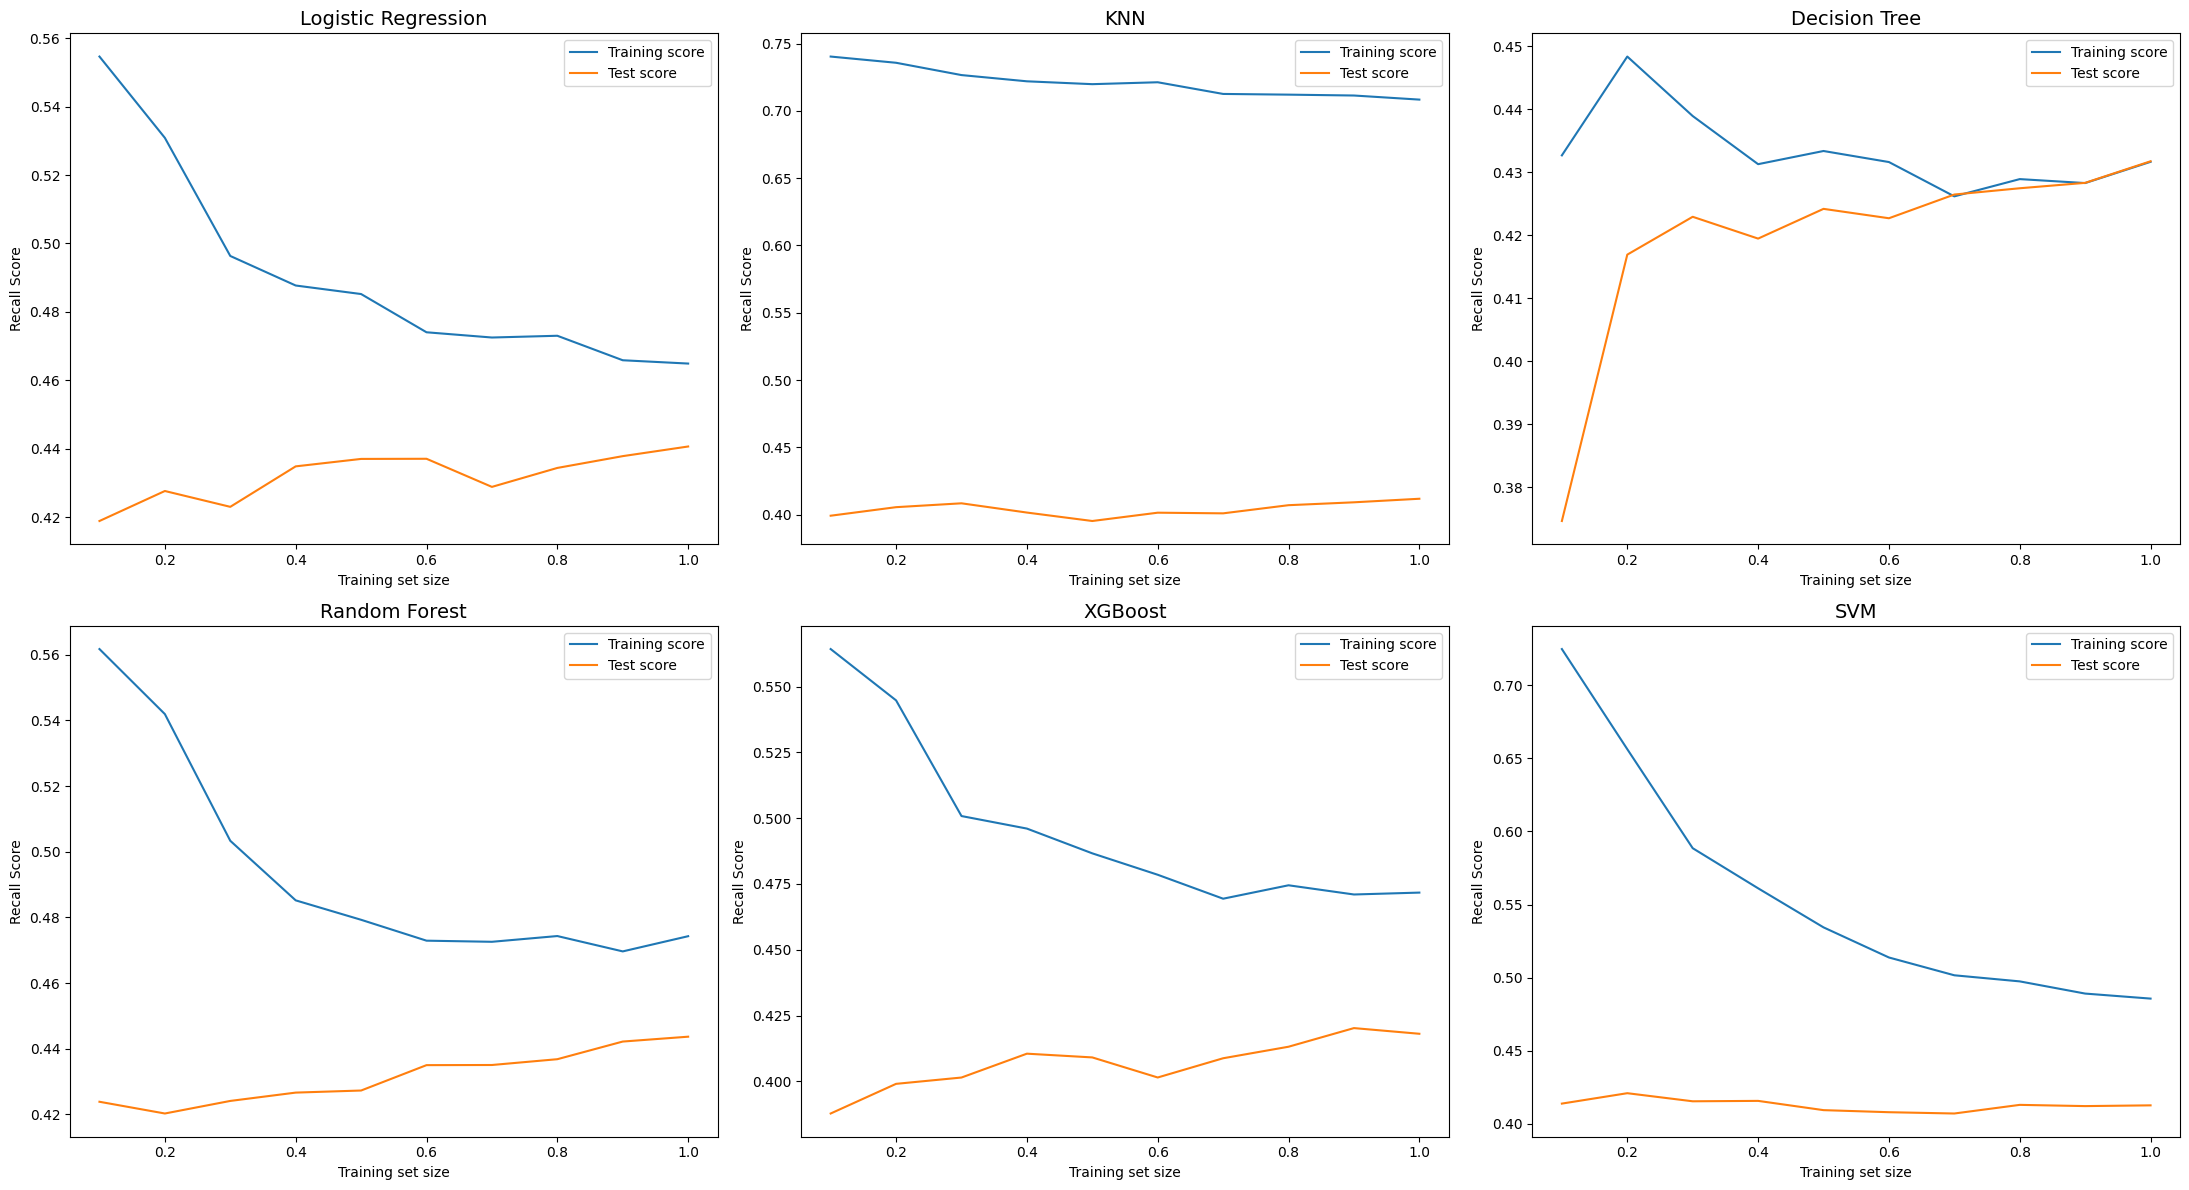

In [41]:
models = {
    'Logistic Regression': best_pipeline_lr,
    'KNN': best_pipeline_knn,
    'Decision Tree': best_pipeline_tree,
    'Random Forest': best_pipeline_forest,
    'XGBoost': best_pipeline_xgb,
    'SVM': best_pipeline_svm
}

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

train_sizes = np.linspace(0.1, 1.0, 10)

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]

    train_sizes_, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        train_sizes=train_sizes,
        cv=5,
        scoring='recall_macro',
        n_jobs=-1
    )

    ax.plot(train_sizes, train_scores.mean(axis=1), label="Training score")
    ax.plot(train_sizes, val_scores.mean(axis=1), label="Test score")
    ax.set_title(name, fontsize=14)
    ax.set_xlabel("Training set size")
    ax.set_ylabel("Recall Score")
    ax.legend()

plt.tight_layout()
plt.show()

### 📝 Model evaluation
- **Logistic Regression**
  - No. Would be difficult to learn the complexity
- **KNN**
  - No. Overfitting andv the data would not suit this model as it has too many dimensions
- **Decision Tree**
  - OK
- **Random Forest, XGBoost, SVM**
  - OK - overfitting --> 💡 Improve with feature engineering

---

## Improve models with feature engineering

### Feature engineering ideas
- Day
  - `is_weekend`
  - `day_period`（morning/afternoon/evening/night)
- Time
  - `hour_bin`
  - `is_rush_hour`

- Weather

- Need more data
  - How far from Hospital?
  - Insurance?
  - TODO: SUM by the region 



In [42]:
pass

### Feature importance

In [106]:
pass

---

In [ ]:
# with open('../models/project_accidents_model.pkl', 'wb') as f:
#     pickle.dump(pipe, f)

In [ ]:
# with open('../models/project_accidents_model.pkl', 'rb') as f:
#     model = pickle.load(f)